<a href="https://colab.research.google.com/github/Depersonalizc/AL-cancer-detection/blob/main/codeWithActiveCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC4080 Midterm Project
## 📝Active Learning for Label-Efficient Histopathologic Cancer Detection


*Group 24* 

- 🐷 CHEN Ang   (118010009)

- 🐸 FU Quanzhi (118010070)








## Prepare data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

!unzip gdrive/Shareddrives/c012-153/data/histopathologic-cancer-detection.zip -d ./data/

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: ./data/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: ./data/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: ./data/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: ./data/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: ./data/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: ./data/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: ./data/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: ./data/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: ./data/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: ./data/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: ./data/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: ./data/train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  


In [5]:
%matplotlib inline
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 200

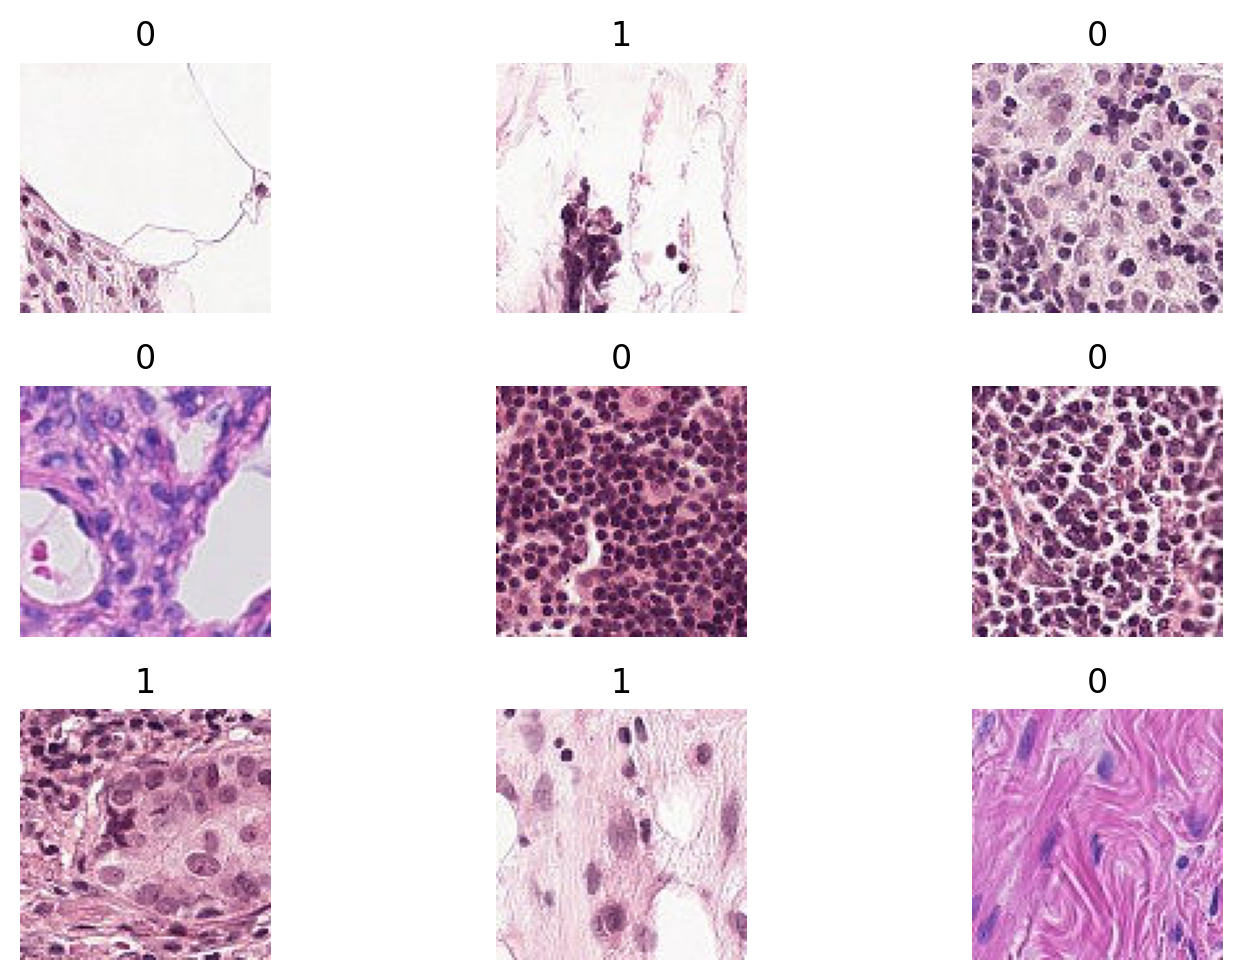

In [6]:
df = pd.read_csv("./data/train_labels.csv")
df = df[:10000]
fig = plt.figure(figsize=(8,5))
for i in range(9):
    fig.add_subplot(3, 3, i + 1)
    fname = f"./data/train/{df.id[i]}.tif"
    plt.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
    plt.title(df.label[i]); plt.axis("off")
fig.tight_layout()

In [7]:
from concurrent import futures
from functools import partial
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset


def pmap(f, iterable, max_threads=None, show_pbar=False, **kwargs):
    """Concurrent version of map()."""
    with futures.ThreadPoolExecutor(max_threads) as executor:
      if show_pbar:
        results = tqdm(executor.map(f, iterable, **kwargs))
      else:
        results = executor.map(f, iterable, **kwargs)
      return list(results)


class HistopathologicDataset(Dataset):
    def __init__(self, df, datadir, transform=None, return_idx=False):
        fnames = [f"{datadir}/{i}.tif" for i in df.id]
        labels = df.label.tolist()

        def get_xy(idx):
            x = cv2.imread(fnames[idx])
            y = labels[idx]
            return x, y

        self.items = pmap(get_xy, range(len(df)), show_pbar=True)
        self.transform = transform
        self.return_idx = return_idx
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, index):
        img, label = self.items[index]
        if self.transform:
            img = self.transform(img)
        if self.return_idx: return img, label, index
        return img, label


            

In [13]:
from torchvision import transforms, models

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

# df = df[:500]
split = int(0.8 * len(df))
batch_size = 128
val_batch_size = 1024
train_dataset = HistopathologicDataset(df[:split], "./data/train", train_transforms)
valid_dataset = HistopathologicDataset(df[split:], "./data/train", valid_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size)

8000it [00:01, 7228.26it/s]
2000it [00:00, 6582.94it/s]


## Model

In [9]:
from torch import nn
from copy import deepcopy

resnet = models.resnet50(pretrained=True)

in_features = resnet.fc.in_features
num_hidden = 512

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

active_model = deepcopy(model)
random_model = deepcopy(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Training

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def train(train_loader, model, criterion, optimizer, scheduler):
    total_loss = 0.0
    size = len(train_loader.dataset)
    # num_batches = size // train_loader.batch_size
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # print(f"Training: {i}/{num_batches}")
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        optimizer.zero_grad()
        loss.backward()  # backprogagation
        optimizer.step()
        # scheduler.step()
    scheduler.step()
    return total_loss / size


def validate(valid_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_loss = 0.0
        size = len(valid_loader.dataset)
        # num_batches = size // valid_loader.batch_size
        for i, (images, labels) in enumerate(valid_loader):
            # print(f"Validation: {i}/{num_batches}")
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_loss += loss.item() * images.size(0)
            
        return total_loss / size, total_correct.double() / size


def fit(model, num_epochs, train_loader, valid_loader):
    from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # scheduler = OneCycleLR(optimizer, max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(train_loader))
    scheduler = CosineAnnealingLR(optimizer, num_epochs*.9, 1e-4)
    print("epoch\ttrain loss\tvalid loss\taccuracy")
    for epoch in range(num_epochs):
        train_loss = train(train_loader, model, criterion, optimizer, scheduler)
        valid_loss, valid_acc = validate(valid_loader, model, criterion)
        print(f"{epoch}\t{train_loss:.5f}\t\t{valid_loss:.5f}\t\t{valid_acc:.3f}")

In [83]:
# model = model.to(device)
# fit(model, 20, train_loader, valid_loader)

epoch	train loss	valid loss	accuracy
0	0.51523		0.41846		0.818


In [31]:
from collections import defaultdict
def randomCycle(model, num_cycle=10, size=50):
  randomIdx = np.random.choice(len(df), size*num_cycle, replace=False)
  random_set = []
  for n in range(num_cycle):

    selected_idx = randomIdx[n*size:n*size+size]
    random_set.extend(selected_idx)
    new_dataset = HistopathologicDataset(df.iloc[random_set,:], "./data/train", train_transforms, return_idx=False)
    new_dataloader = DataLoader(new_dataset, batch_size=batch_size)
    fit(model, 5, new_dataloader, valid_loader)
    print("-"*20+f"{len(random_set)} Sample selected; {n}th Cycle End"+"-"*20)
  return random_set 


def activeCycle(active_loader, model, threshold, num_cycle=10, size=50):
    '''
    Input model and dataloader
    Output "Hard Data"
    '''
    # Select Hard Index
    active_set = []
    for n in range(num_cycle):
      model.eval()
      with torch.no_grad():
          total_correct = 0
          total_loss = 0.0
          size = len(active_loader.dataset)
          selected_idx = []
          idx_prob = defaultdict(float)
          # num_batches = size // valid_loader.batch_size
          for i, (images, labels, idx) in enumerate(active_loader):
              # print(f"Validation: {i}/{num_batches}")
              
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              prob = nn.functional.softmax(outputs, dim = 1)
              prob, indexes = prob.max(1)
              for i in range(len(prob)): idx_prob[idx[i].item()] = prob[i].item()
              
              selected_idx.extend([*idx[prob<threshold].numpy().tolist()])
      selected_idx = set(selected_idx)
      selected_idx = list(selected_idx-set(active_set))
      selected_idx.sort(key=lambda x: idx_prob[x])
      active_set.extend(selected_idx[:50] if len(selected_idx)>50 else selected_idx)
      new_dataset = HistopathologicDataset(df.iloc[active_set,:], "./data/train", train_transforms, return_idx=False)
      new_dataloader = DataLoader(new_dataset, batch_size=batch_size)
      fit(model, 5, new_dataloader, valid_loader)
      print("-"*20+f"{len(active_set)} Sample selected; {n}th Cycle End"+"-"*20)
    return active_set 


In [90]:
model = model.to(device)
pretrain_dataset = HistopathologicDataset(df[:int(0.05*len(df))], "./data/train", train_transforms)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=batch_size)
fit(model, 4, pretrain_loader, valid_loader)

500it [00:00, 186762.13it/s]


epoch	train loss	valid loss	accuracy
0	0.34532		0.35987		0.845
1	0.32709		0.36126		0.842
2	0.35223		0.95958		0.794
3	0.34025		0.33980		0.863


In [ ]:
# active_model = nn.Sequential(
#     nn.Sequential(*list(resnet.children())[:-2]),
#     head
# )
# active experiment
active_model = deepcopy(model)
active_model = active_model.to(device)
active_dataset = HistopathologicDataset(df[:split], "./data/train", valid_transforms, return_idx=True)
active_loader = DataLoader(active_dataset, batch_size=batch_size)
active_set = activeCycle(active_loader, active_model, 0.6, 10)

8000it [00:01, 7840.82it/s]
50it [00:00, 13956.82it/s]


epoch	train loss	valid loss	accuracy
0	0.73158		1.04589		0.407


In [32]:
# random experiment
random_model = deepcopy(model)
random_model = random_model.to(device)
randomCycle(random_model, num_cycle=10, size=50)


50it [00:00, 50827.73it/s]


epoch	train loss	valid loss	accuracy
0	0.83349		0.66602		0.577
1	0.67129		1.32557		0.408
2	0.55461		0.90906		0.564
3	0.41200		0.83240		0.592
4	0.26608		0.80867		0.607
--------------------50 Sample selected; 0th Cycle End--------------------


100it [00:00, 34804.61it/s]

epoch	train loss	valid loss	accuracy


0	0.65730		11.55870		0.404
1	1.55482		4.64667		0.512
2	0.29263		2.66847		0.645
3	0.26549		2.00269		0.699
4	0.21704		1.77064		0.700
--------------------100 Sample selected; 1th Cycle End--------------------


150it [00:00, 35742.85it/s]

epoch	train loss	valid loss	accuracy


0	0.65604		14.64378		0.465
1	0.64052		45.56336		0.416
2	0.40419		13.84577		0.513
3	0.46615		4.71018		0.553
4	0.40956		1.95570		0.590
--------------------150 Sample selected; 2th Cycle End--------------------


200it [00:00, 17139.90it/s]

epoch	train loss	valid loss	accuracy


0	0.74354		195.86803		0.438
1	0.62730		2.37003		0.637
2	0.43429		2.97878		0.699
3	0.32694		1.24926		0.695
4	0.34299		0.73778		0.704
--------------------200 Sample selected; 3th Cycle End--------------------


250it [00:00, 16704.52it/s]

epoch	train loss	valid loss	accuracy


0	0.58519		1.50064		0.623
1	0.48318		14.25168		0.657
2	0.36108		6.92646		0.734
3	0.32409		2.62954		0.750
4	0.29098		1.25478		0.756
--------------------250 Sample selected; 4th Cycle End--------------------


300it [00:00, 7919.31it/s]

epoch	train loss	valid loss	accuracy


0	0.56254		2.80542		0.763
1	0.36631		0.85666		0.736
2	0.35391		0.56563		0.777
3	0.41540		0.52138		0.788
4	0.32551		0.51211		0.787
--------------------300 Sample selected; 5th Cycle End--------------------


350it [00:00, 22661.06it/s]

epoch	train loss	valid loss	accuracy


0	0.42900		1.00001		0.756
1	0.34411		0.97798		0.758
2	0.28516		0.68402		0.760
3	0.27202		0.51034		0.775
4	0.25943		0.49218		0.785
--------------------350 Sample selected; 6th Cycle End--------------------


400it [00:00, 12633.16it/s]

epoch	train loss	valid loss	accuracy


0	0.36644		0.93966		0.624
1	0.50000		5.54780		0.776
2	0.35426		2.65646		0.787
3	0.38765		0.97488		0.803
4	0.35671		0.66901		0.804
--------------------400 Sample selected; 7th Cycle End--------------------


450it [00:00, 8926.12it/s]

epoch	train loss	valid loss	accuracy


0	0.44740		0.63802		0.793
1	0.46616		0.70144		0.769
2	0.40626		0.57912		0.762
3	0.36502		0.53392		0.770
4	0.31495		0.50566		0.787
--------------------450 Sample selected; 8th Cycle End--------------------


500it [00:00, 8365.39it/s]


epoch	train loss	valid loss	accuracy
0	0.36298		0.67926		0.780
1	0.36908		0.71445		0.754
2	0.31866		0.50753		0.800
3	0.27046		0.52246		0.794
4	0.28596		0.49968		0.807
--------------------500 Sample selected; 9th Cycle End--------------------


[852,
 922,
 4635,
 575,
 3217,
 4361,
 9674,
 1541,
 2106,
 9640,
 9506,
 5889,
 9509,
 9518,
 1330,
 3278,
 3921,
 2494,
 9339,
 4254,
 6572,
 4607,
 4141,
 9623,
 6668,
 4700,
 3734,
 6108,
 3089,
 5675,
 9284,
 3808,
 6521,
 3173,
 1921,
 9842,
 8286,
 8291,
 8670,
 117,
 6506,
 1376,
 3576,
 6595,
 106,
 4851,
 9617,
 3382,
 9546,
 7376,
 7310,
 5206,
 3732,
 6022,
 9704,
 9348,
 3906,
 3604,
 5211,
 5305,
 9777,
 598,
 748,
 9265,
 2257,
 8026,
 6286,
 1277,
 5585,
 1395,
 1750,
 3655,
 1258,
 1809,
 5094,
 3605,
 5294,
 314,
 8634,
 4644,
 7065,
 1523,
 21,
 7981,
 2253,
 6169,
 3954,
 5009,
 1778,
 7003,
 7156,
 6118,
 7181,
 5536,
 3871,
 6741,
 1563,
 6382,
 5338,
 6987,
 8559,
 9782,
 9325,
 7572,
 6824,
 6932,
 6927,
 4036,
 5448,
 6663,
 2522,
 32,
 7507,
 1821,
 373,
 8863,
 1851,
 3693,
 403,
 8894,
 5283,
 1041,
 5668,
 4838,
 8916,
 1024,
 6471,
 5945,
 1197,
 469,
 4484,
 383,
 5886,
 6364,
 7983,
 5317,
 865,
 8891,
 1132,
 9167,
 7205,
 654,
 7011,
 9293,
 3394,
 75

In [12]:
validate(valid_loader, active_model, nn.CrossEntropyLoss())


(0.6293804922103882, tensor(0.8025, device='cuda:0', dtype=torch.float64))

In [116]:
# random_model = nn.Sequential(
#     nn.Sequential(*list(resnet.children())[:-2]),
#     head
# )
random_model = deepcopy(model)
random_model = random_model.to(device)
pretrain_dataset = HistopathologicDataset(df[:500], "./data/train", train_transforms)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=batch_size)
fit(random_model, 20, pretrain_loader, valid_loader)


500it [00:00, 13403.33it/s]


epoch	train loss	valid loss	accuracy
0	0.81712		2.06037		0.450
1	0.64209		3.98989		0.533
2	0.46613		1.13737		0.759
3	0.41359		0.65917		0.785
4	0.40538		0.54428		0.790
5	0.34401		0.49018		0.803
6	0.34071		0.87625		0.764
7	0.32920		1.35900		0.767
8	0.27914		1.15996		0.773
9	0.24903		0.85336		0.782
10	0.18541		0.65165		0.788
11	0.15945		0.58171		0.797
12	0.15026		0.62623		0.796
13	0.14412		0.69673		0.778
14	0.23447		1.16278		0.769
15	0.27733		0.93842		0.783
16	0.27855		0.88580		0.777
17	0.20718		0.69592		0.779
18	0.21642		0.58783		0.792
19	0.15082		0.53246		0.789


In [ ]:
validate(valid_loader, random_model, nn.CrossEntropyLoss())

In [18]:
a = []
a.extend([1,2])
a

[1, 2]